In [ ]:
!pip uninstall rulprediction --yes

In [1]:
!pip install git+https://github.com/sashaatlasov/RUL-Prediction.git

  Cloning https://github.com/sashaatlasov/RUL-Prediction.git to /private/var/folders/cr/12mnwryn4bj3dhrct6_xvw340000gn/T/pip-req-build-9ut86pz2
  Running command git clone --filter=blob:none --quiet https://github.com/sashaatlasov/RUL-Prediction.git /private/var/folders/cr/12mnwryn4bj3dhrct6_xvw340000gn/T/pip-req-build-9ut86pz2
  Resolved https://github.com/sashaatlasov/RUL-Prediction.git to commit 4919c7f3ac549d2ce539bbf3fa12df295d872202
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

### Loading dataset

In [3]:
class CMAPSS(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        target = torch.tensor(self.y[idx], dtype=torch.float32)
        sensors = torch.tensor(self.X[idx], dtype=torch.float32)
        return target, sensors.squeeze(-1)

In [4]:
def get_data(k):
    X_train = sio.loadmat(f'data/F00{k}/trainX.mat')['trainX']
    X_test = sio.loadmat(f'data/F00{k}/testX.mat')['testX']

    y_train = sio.loadmat(f'data/F00{k}/trainY.mat')['trainY'].T
    y_test = sio.loadmat(f'data/F00{k}/testY.mat')['testY'].T
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=1)
    
    train_data = CMAPSS(X_train, y_train) 
    val_data = CMAPSS(X_val, y_val) 
    test_data = CMAPSS(X_test, y_test) 
                        
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=256)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=256)
                        
    return train_loader, val_loader, test_loader

### Model training

In [5]:
from rulpred.RULprediction import RULpredictor
from rulpred.training import *

from hparams import config

def main(k, device='cpu'):
    if k % 2 == 0:
        win_size = 60
    else:
        win_size = 40
        
    model = RULpredictor(win_size, config['betas'], config['num_timesteps'], config['rul_max'],
                        **config['dast_conf'])
    model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=config["learning_rate_start"])
    train_dataloader, val_dataloader, test_dataloader = get_data(k)

    for i in range(1, config['epochs'] + 1):
        loss = train_epoch(model, train_dataloader, optim, device=device)
        if i % 10 == 0:
            val_loss = validate(model, val_dataloader, device)
    test_loss = validate(model, test_dataloader, device)
    torch.save(model, f'Model_F00{k}.pt')

In [6]:
main(1)

100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


### Loading checkpoints

In [7]:
model = torch.load('Model_F001.pt')
dast = torch.load('DAST_F001.pth')

In [9]:
data = sio.loadmat('data/plot_testX_F001.mat')
X_test = data['testX']
y_test = data['testY'].T
masks = data['mask'].T

### Plot trajectories

In [10]:
from rulpred.evaluation.plot_prediction import plot_traj

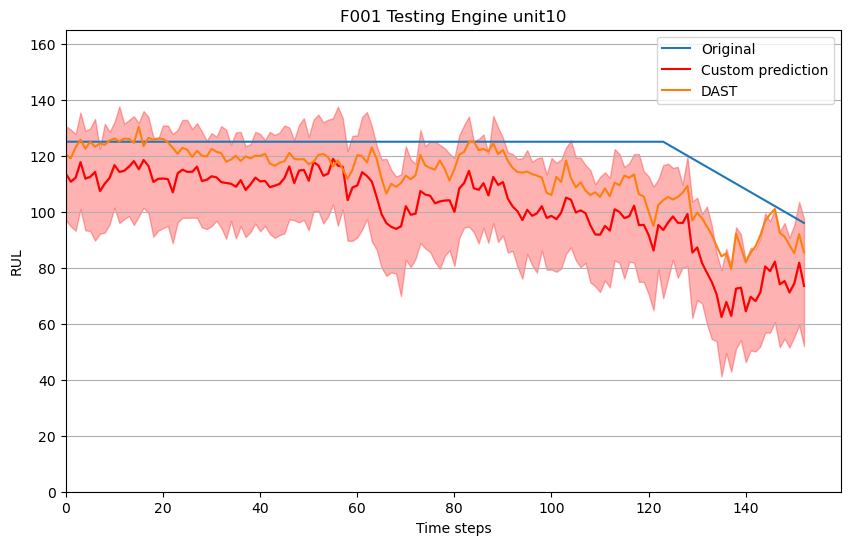

In [11]:
plot_traj(10, model, dast, X_test, y_test, masks)

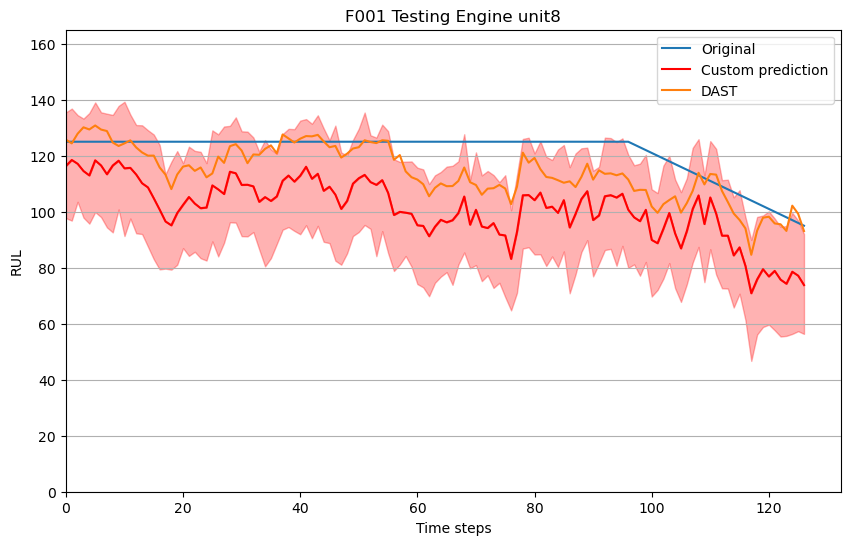

In [12]:
plot_traj(8, model, dast, X_test, y_test, masks)

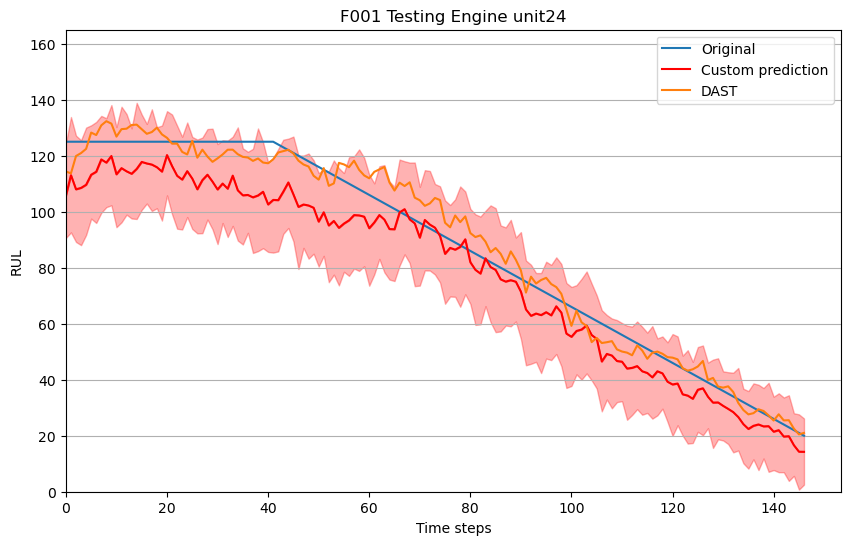

In [13]:
plot_traj(24, model, dast, X_test, y_test, masks)

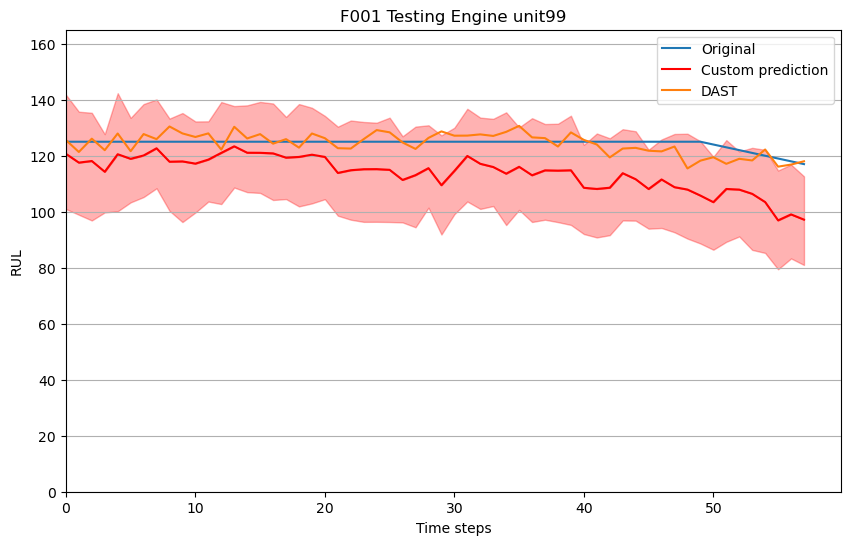

In [14]:
plot_traj(99, model, dast, X_test, y_test, masks)